# Zadanie 5


## Przygotowywania do zadania 

### Wczytywanie potrzebnych bibliotek

In [20]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math

### Ustawianie globalnych danych

Ustawiam tutaj, dane które są uniwersalne dla każdego testu, to znaczy:

1. Liczba stopni swobody
2. Liczba danych
3. Liczba symulacji, które wykonam
4. Poziom istnotności


In [21]:
np.random.seed(123)

# Zakres stopni swobody, jakie zaprezentuję na wykresie
stopnie_swobody = range(1, 50, 1)  # Zakres od 1-50 co 1
# Ustalam poziom istotności
poziom_istotnosci = 0.05
# Liczba danych dla jakich wykonam symulacje
liczby_danych = [10, 20, 50, 100, 200]
# Liczba symulacji na jakich będę bazować
liczba_symulacji = 3000
# Czcionka dla tytulu
font_title = {'family' :'serif','size':17}

## Badanie 

### Potrzebne funkcje 

Tutaj stworzę wszystkie funkcje, które wykorzystam do badania, przy okazji opisując od razu ich działanie. Następnie przy symulacji badania, będą one tylko wywoływane. Funkcje zaczynają się od najbardziej ogólnej i idą w dół razem z programem(idziemy po kolei tak samo jak program).

#### Funkcja obliczania mocy testu 

Najogólniejsza funkcja, która przygotuje dane, które wykorzystam, aby zrobić symulacje w funkcji symulacja. Więc ustalamy liczbę danych oraz stopień swobody i idziemy dalej przekazując parametry dalej do funkcji. Po symulacji dodajemy wynik do tablicy i idziemy dalej. Od razu wybieram czy to będzie klasyczny sposób testowania czy z wykorzystaniem PIT. 

Argumenty: 
- test - Mówi który test jest symulowany
- PIT - Czy testujemy z wykorzystaniem PIT

Funkcja będzie zwracać tablice 2D(i,j), która zbierała dane dla i-tej liczbie danych oraz j-tych stopni swobody.



In [22]:
def obliczanie_mocy_testu(test,PIT):
    # Tablica, która zbierze mi moce testów, które zwróci
    moce_testow = []

    # Dla każdej liczby z liczby_danych
    for l_danych in liczby_danych:
        """
        Tworzę nową tablicę która przechowuję wyniki mocu testu dla i-tej liczby danych. Lista przechowuje wyniki dla każdego j-stopnia
        swoobody w stopnie_swobody. Wykorzystuje List Comprahension, żeby umilic kod
        """
        moce_testow.append([symulacja(l_danych,s_stopien,test,PIT) for s_stopien in stopnie_swobody])



    # Zwracam w.w tablice
    return moce_testow

#### Funkcja symulacji 

Ustaliliśmy już liczbę danych oraz liczbe stopni swobody dla naszych danych. 
W tej funkcji będziemy generować dane z rozkładu t-studenta dokładnie z tymi parametrami, przekazanymi jako argumenty. 
Następnie prześlemy je do funkcji, która wybierze, który test jest obecnie symulowany i wynik tej funkcji będziemy sumować w zmiennej 
suma_odrzucen_H0.

Argumenty:
- l_danych - Ile danych będziemy losować z rozkładu t-studenta 
- s_stopien - Liczba stopni swobody dla rozkładu t-studenta
- test - Jaki test jest obecnie symulowany
- PIT - Czy testujemy z wykorzystaniem PIT

Funkcja będzie zwracać odsetek w jakim odrzuciłem hipotezę zerową dla podanych parametrów

In [23]:
def symulacja(l_danych,s_stopien,test,PIT):
    # W tej zmiennej będę sumował ile razy odrzuciłem hipotezę zerową dla danego zestawu 
    suma_odrzucenia_H0 = 0

    # Tutaj będzie symulacja
    for k in range(liczba_symulacji):
        # Tworzę próbkę danych z rozkładu t-Studenta o l_danych wielkości oraz s_stopien stopni swobody
        probka = stats.t.rvs(s_stopien,size=l_danych)

        # Następnie przekazuje wszystkie dane, aby wybrac który test jest symulowany i dowiedzieć się jaki jest wynik testu
        suma_odrzucenia_H0 += wybor_testu(probka,test,s_stopien,PIT)

    # Zwracam odsetek odrzucenia hipotezy zerowej
    return suma_odrzucenia_H0/liczba_symulacji

#### Funkcja wyboru testu 

Funkcja za argumenty przyjmuje wszystkie dane, które są jej potrzebne do wybrania oraz przeprowadzenia danego testu. 
Argumenty, to:
- test - Jaki test ma zostać wykonany
- probka - Zestandaryzowany zestaw danych, które będziemy badać
- PIT - Jaki sposob testowania
- s_stopein - Liczba stopni swobody 

Funkcja będzie zwracać 1 lub 0 w zależności od wyniku testu(1-odrzucamy test, 0-nie ma podstaw)

In [24]:

def wybor_testu(probka,test,s_stopien,PIT):

    """
    Ogólna zasada działania testów:
    
    Jezali PIT jest true to wykorzystujemy je do testowania co znaczy ze przeksztalcamy probke na Fx(x)
    i porownujemy ja z rozkladem jednostajnym. Jezeli nie to mamy do czynienia z klasycznym sposobem 
    testowania i postepujemy normalnie.

    Jeżeli pvalue z danego testu jest mniejsze niż wczesniej ustalony poziom istotnotnosci to odrucamy 
    Hipoteze zerowa co znaczy ze zwracamy wartość 1. W przeciwnym wypadku zwracamy 0
    
    """

    # Najpierw podejmiemy wybór jaki test mamy wykonać

    # Test Kolgomorova
    if test == "kol":
        pval = None
        # Proceudra PIT
        if PIT:
            # Zamiana na Fx(x)
            probka = stats.t.cdf(probka,df=s_stopien)
            # Uzyskanie pvalue
            pval = stats.kstest(probka,'uniform').pvalue

        # Normalny sposob testowania  
        else:
            pval = stats.kstest(probka,'t',args=(s_stopien,)).pvalue

        # Po uzyskaniu pvalue sprawdzam wartosc 
        if pval <0.05: return 1        



    # Test Chi kwadrat
    elif test == "chi":
        pval = None
        # Proceudra PIT
        if PIT:
            # Zamiana na Fx(x)
            probka = stats.t.cdf(probka,df=s_stopien)
            # Uzyskanie wartosci oczekiwanych
            fobs,fexp = wartosci_dla_chi2(probka,s_stopien,PIT)
            # Uzyskanie pvalue
            pval = stats.chisquare(fobs,f_exp=fexp).pvalue

        # Normalny sposob testowania  
        else:
             # Uzyskanie wartosci oczekiwanych
            fobs,fexp = wartosci_dla_chi2(probka,s_stopien,PIT)
            # Uzyskanie pvalue
            pval = stats.chisquare(fobs,f_exp=fexp).pvalue

        # Po uzyskaniu pvalue sprawdzam wartosc 
        if pval <0.05: return 1    
    
    # Jeżeli do tej pory nie zwrócono 1 to znaczy, że żaden z testów nie odrzucił H0 więc możemy zwrócic 0
    return 0
            


#### Funckja ustalenia wartości oczekiwanych 

Ta funkcja ma na celu przygotowanie danych utworzynych do tej pory do testu chi kwadrat(podzialu dany na przedzialy i policzenie czestotliowosci występowania danych). Zwraca gotowe do wykorzystania zestawy danych w tescie chi kwadrat. Bierze pod uwage sposob testowania w ten sposob, że losuje wtedy liczby albo z rozkladu jednostajnego albo chi kwadrat.

In [25]:
def wartosci_dla_chi2(probka,s_stopien,PIT):
    """
    Jest to funkcja która zwróci 2 zbiory: zbior zaobserwowanych wartosci(na podstawie probki przekazanej do 
    funkcji) oraz zbior wartosci oczekiwanych potrzebnych do testu Chi kwadrat. Zaczne od wylosowania probki 
    z rozkładu chi2 z parametrami takimy jakimi standaryzowałem oryginalna probke. Nastepnie podziele je 
    na przedzialy zawierajce czestotliwosci wystepowania dane. Na koniec wyrównam róznice w sumie tych tablic,
    aby uniknac pozniejszych bledow. Od tego jaka probke będe losowal czy z rozkladu X czy z jednostajnego zalezy 
    od parametru PIT(sposobu testowania)    
    """
    # Losuje probke z rozkladu chi2/jednostajnego o parametrach z proby
    if PIT:
        probka_chi2_or = stats.uniform.rvs(size = len(probka))
    else:
        probka_chi2_or = stats.t.rvs(size = len(probka),df = s_stopien)

    # Dzielenie danych na przedzialy
    probka_chi2_or, przedzialy = np.histogram(probka_chi2_or,bins='auto')
    
    # Teraz tam gdzie przedzial ma czestotliwosc 0(co prowadzi do wysypania sie testu chi kwadrat) łącze zewnetrzne
    # przedzialy w jedno
    indexes = np.nonzero(probka_chi2_or==0)[0]
    probka_chi2_or = probka_chi2_or[probka_chi2_or != 0]
    przedzialy = np.delete(przedzialy,indexes)

    #Teraz dziele na przedzialy probke pochodzaca z chi2 oryginalnej
    probka, _ = np.histogram(probka,bins=przedzialy)

    # Teraz wyrownuje roznice w sumach tych tablic dajac obserwacje ktore sie nie zmiescily w tym zasiego do ostatnich 
    # przedzialow 
    roznica = sum(probka_chi2_or) - sum(probka)
    probka[0] += math.ceil(roznica/2)
    probka[-1] += math.floor(roznica/2)
    
    # Zwracam tablice gotowe do testu
    return probka,probka_chi2_or



## Symulacje 

### Klasyczny sposób testowanaia

In [26]:
moc_kolgom = obliczanie_mocy_testu("kol",False)
moc_chi = obliczanie_mocy_testu("chi",False)


### Testowanie z wykorzystaniem PIT

In [27]:
moc_kolgom_pit = obliczanie_mocy_testu("kol",True)
moc_chi_pit = obliczanie_mocy_testu("chi",True)


## Wnioski 

### Test Kołgomorowa

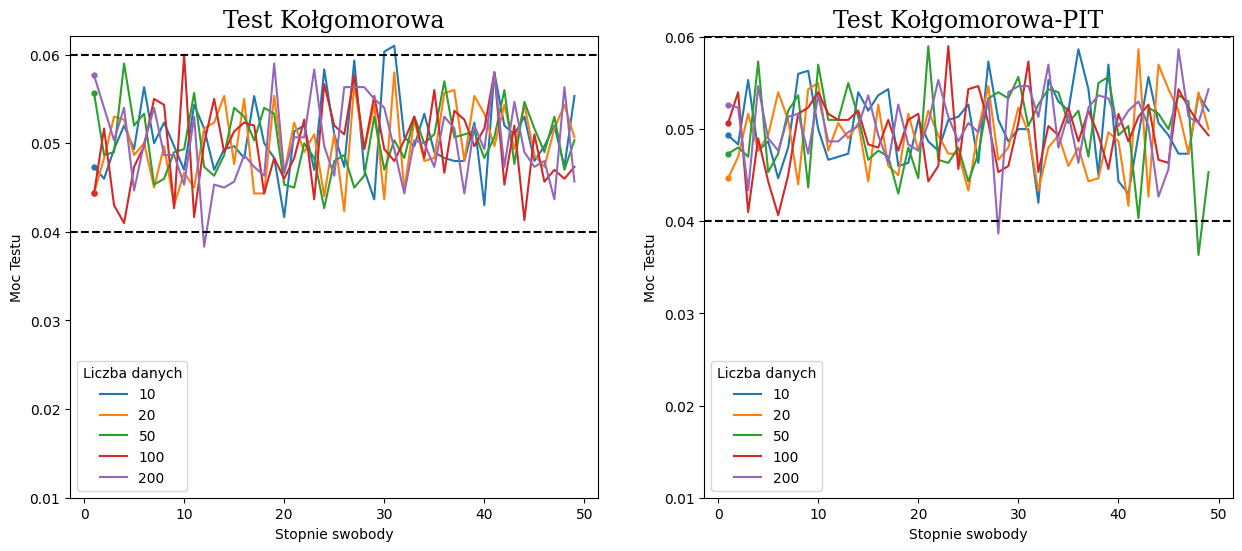

In [45]:
fig, (kol,kol_pit) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns

# Dodaje dane do wykres
for i,moc in enumerate(moc_kolgom):
    kol.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    kol.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 

for i,moc in enumerate(moc_kolgom_pit):
    kol_pit.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    kol_pit.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 


# Dodaje opisy do wykresu test kolgomorowa
kol.set_xlabel("Stopnie swobody")
kol.set_ylabel("Moc Testu")
kol.set_title("Test Kołgomorowa",fontdict=font_title)
kol.legend(title="Liczba danych",loc="lower left")
kol.set_ylim(0.01)
kol.axhline(y=0.06, linestyle='--', color='black')
kol.axhline(y=0.04, linestyle='--', color='black')

# Dodaje opisy do wykresu 
kol_pit.set_xlabel("Stopnie swobody")
kol_pit.set_ylabel("Moc Testu")
kol_pit.set_title("Test Kołgomorowa-PIT",fontdict=font_title)
kol_pit.legend(title="Liczba danych",loc="lower left")
kol_pit.set_ylim(0.01)
kol_pit.axhline(y=0.06, linestyle='--', color='black')
kol_pit.axhline(y=0.04, linestyle='--', color='black')



# plt.tight_layout()
plt.show()


### Wnioski

Jak możemy zauważyć na wykresie test kołgomorowa jest bardzo dokładny(błąd szacunku wynosi jedyni okolo 0.01 w obie strony co jest dobrym wynikiem), poniewaz krąży wokol oczekiwanej wartosci jaka jest wartosc poziomu istotnosci. Test jest na tyle dokladny, że nie ma żadnej różnicy w sposobie testowania(klasyczne a testowanie wykorzystująć PIT (probability integral transform)). 

### Test chi-kwadrat

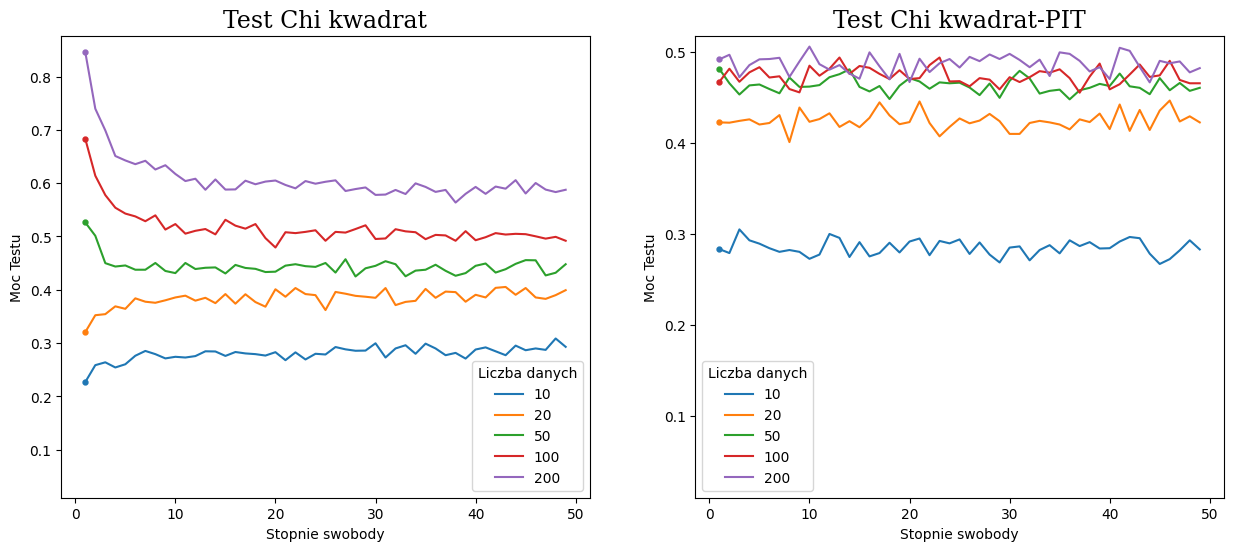

In [29]:
fig, (chi,chi_pit) = plt.subplots(1,2, figsize=(15,6))  # 1 row, 2 columns

# Dodaje dane do wykres
for i,moc in enumerate(moc_chi):
    chi.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    chi.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 

for i,moc in enumerate(moc_chi_pit):
    chi_pit.plot(stopnie_swobody,moc,label= str(liczby_danych[i]))
    chi_pit.scatter(stopnie_swobody[0], moc[0], s=50, marker='.') 


# Dodaje opisy do wykresu test kolgomorowa
chi.set_xlabel("Stopnie swobody")
chi.set_ylabel("Moc Testu")
chi.set_title("Test Chi kwadrat",fontdict=font_title)
chi.legend(title="Liczba danych",loc="lower right")
chi.set_ylim(0.01)



# Dodaje opisy do wykresu 
chi_pit.set_xlabel("Stopnie swobody")
chi_pit.set_ylabel("Moc Testu")
chi_pit.set_title("Test Chi kwadrat-PIT",fontdict=font_title)
chi_pit.legend(title="Liczba danych",loc="lower left")
chi_pit.set_ylim(0.01)




# plt.tight_layout()
plt.show()


#### Wnioski

Jak można zauważyć na wykresie test chi kwadrat nie jest zbyt dokładny, szczególnie dla dużych danych, dzięki jego niedokładności możemy jednak zauważyć różnice pomiędzy sposobem testowania. Mianowicie testowanie PIT okazuję się lepsze dla dużej ilości danych, bo uzyskuje lepsze(blizsze oczekiwanej wartości) rezultaty, ale za to dla mniejszej ilosci danych myli sie bardziej niz klasyczny sposob testowania. Czyli powinnismy uzywac dla wiekszej liczby danych badanych. Ogólnie klasyczna metoda testowania jest w przedziale od <0.2,0.85>, czyli ma duży rozrzut wyników natomiast PIT jest w przedziale <0.28,0.6>(warto tutaj wspomniec ze i tak wiekszosc wynikow jest w przedziale <0.4,0.6>), czyli jest bardziej skupiony co nie znaczy, że lepszy.  

## Porównanie 
Wyliczę średnią moc każdego z testów dla każdego stopnia swobody, co pomoże pokazać mi różnice.


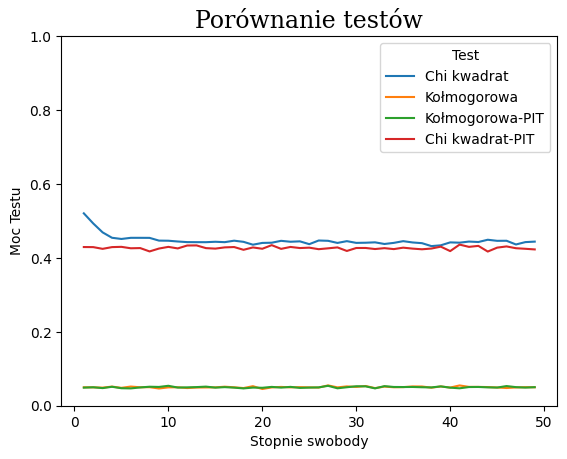

In [30]:
# Tworzenie tablic w których będę trzymał średnie 
srednia_moc_chi = np.zeros(len(stopnie_swobody))
srednia_moc_kol = np.zeros(len(stopnie_swobody))
srednia_moc_chi_pit = np.zeros(len(stopnie_swobody))
srednia_moc_kol_pit = np.zeros(len(stopnie_swobody))


# Sumowanie mocy 
for i in range(len(moc_chi)):
    srednia_moc_chi += moc_chi[i]
    srednia_moc_kol += moc_kolgom[i]
    srednia_moc_chi_pit += moc_chi_pit[i]
    srednia_moc_kol_pit += moc_kolgom_pit[i]


# Wyliczanie średnia 
srednia_moc_chi /= len(moc_chi)
srednia_moc_kol /= len(moc_kolgom)
srednia_moc_chi_pit /= len(moc_kolgom_pit)
srednia_moc_kol_pit /= len(moc_chi_pit)


# Tworzenie wykresu 
w = plt.figure()
plt.plot(stopnie_swobody,srednia_moc_chi,label = "Chi kwadrat")
plt.plot(stopnie_swobody,srednia_moc_kol,label="Kołmogorowa")
plt.plot(stopnie_swobody,srednia_moc_kol_pit,label="Kołmogorowa-PIT")
plt.plot(stopnie_swobody,srednia_moc_chi_pit,label="Chi kwadrat-PIT")
plt.ylim(0,1)
plt.xlabel("Stopnie swobody")
plt.ylabel("Moc Testu")
plt.title("Porównanie testów",fontdict=font_title)
plt.legend(title="Test")
plt.ylim(0,)
plt.show()

### Wnioski

Dla testu kołgoromowa było oczywiste, że średnia mocy testów będzie praktycznie taka sama, bo też same wykresy się prawie pokrywały. Natomiast co jest zaskakujące dla testu chi kwadrat występuje ta sama zależność, co może lekko zaskakiwać, bo tam wykresy zdecydowanie się nie pokrywały. Świadczy to o tym, że testowanie to nie różni się aż tak bardzo i dlatego, że testowalismy to na tak bardzo roznej liczbie danych(od 10 do 200) to te różnice w sposobie testowania się zatarły(ustalilismy wczesniej ze sposob PIT jest lepszy dla duzej liczby danych a klasyczny dla mniejszej, ale jak widac te roznice tutaj sie zacieraja). Wynika z tego, że rozrzut tych wykresów nie ma ostatecznie znaczenia w kwestii badania testu chi kwadrat, ponieważ średni wynik wychodzi taki sam. 